/home/hice1/swise30/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50, Loss: 0.0041087003771099265
Epoch 2/50, Loss: 5.465889640618115e-05
Epoch 3/50, Loss: 1.1762348312913673e-05
Epoch 4/50, Loss: 5.701421505364124e-06
Epoch 5/50, Loss: 4.216412162350025e-06
Epoch 6/50, Loss: 3.640324721345678e-06
Epoch 7/50, Loss: 3.284175272710854e-06
Epoch 8/50, Loss: 2.8170851419417887e-06
Epoch 9/50, Loss: 2.6065970814670434e-06
Epoch 10/50, Loss: 2.363343974138843e-06
Epoch 11/50, Loss: 2.236252366856206e-06
Epoch 12/50, Loss: 2.2349765913531883e-06
Epoch 13/50, Loss: 2.1893629718761076e-06
Epoch 14/50, Loss: 2.393206473243481e-06
Epoch 15/50, Loss: 1.7883477535178828e-05
Epoch 16/50, Loss: 3.3307585545117033e-06
Epoch 17/50, Loss: 2.11859070986975e-06
Epoch 18/50, Loss: 2.267243453388801e-06
Epoch 19/50, Loss: 1.2461119345061889e-05
Epoch 20/50, Loss: 3.3790992665672093e-06
Epoch 21/50, Loss: 9.617699747650477e-06
Epoch 22/50, Loss: 3.378714682185091e-06
Epoch 23/50, Loss: 7.394804579234915e-06
Epoch 24/50, Loss: 2.9677742622880033e-06
Epoch 25/50, Los

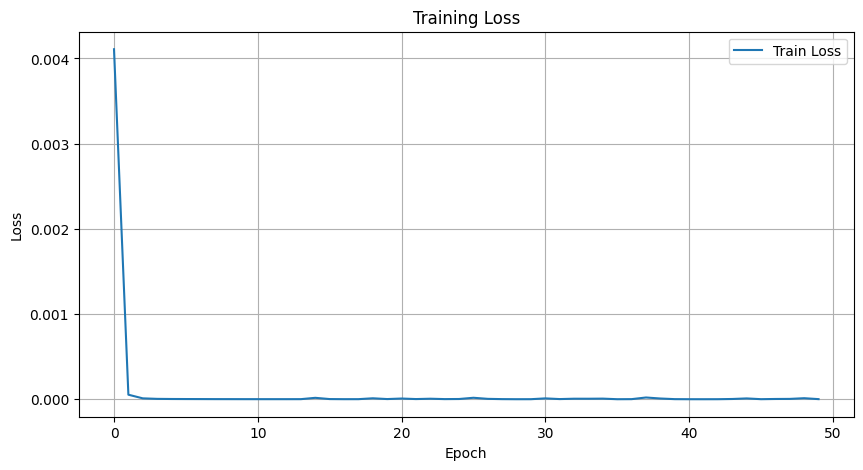

In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, ViTMAEForPreTraining

# The RGB and Generated Images dataset from folder
class RGBImages(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Load pretrained ViT-MAE model and processor
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset_path = "/home/hice1/swise30/mae thermal"
dataset = RGBImages(folder_path=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialize storage for metrics
metrics = {"train_loss": []}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
total_epoch_loss = []
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        images = batch.to(device)

        # Prepare inputs for the model
        inputs = processor(images=images, return_tensors="pt").to(device)

        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    total_epoch_loss.append(epoch_loss)
    metrics["train_loss"].append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

# Save metrics to a JSON file
os.makedirs("/home/hice1/swise30/training_results_thermal_gen", exist_ok=True)
with open("/home/hice1/swise30/training_results_thermal_gen/metrics.json", "w") as f:
    json.dump(metrics, f)

# Save the trained model
model_save_path = "/home/hice1/swise30/training_results_thermal_gen/trained_model"
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# Plot and save Loss graph
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("/home/hice1/swise30/training_results_thermal_gen/training_loss.png")
plt.show()


In [2]:
import numpy as np
loss_np = np.array(total_epoch_loss)
print(loss_np)

# Calculate average mask ratio
# Calculate average mask ratio
average_loss = np.mean(loss_np)
std_loss = np.std(loss_np)
print(f"\n")
print(f"Average Mask Ratio: {average_loss:.2%}")
print(f"Standard Deviation of Mask Ratio: {std_loss:.2%}")

[4.10870038e-03 5.46588964e-05 1.17623483e-05 5.70142151e-06
 4.21641216e-06 3.64032472e-06 3.28417527e-06 2.81708514e-06
 2.60659708e-06 2.36334397e-06 2.23625237e-06 2.23497659e-06
 2.18936297e-06 2.39320647e-06 1.78834775e-05 3.33075855e-06
 2.11859071e-06 2.26724345e-06 1.24611193e-05 3.37909927e-06
 9.61769975e-06 3.37871468e-06 7.39480458e-06 2.96777426e-06
 4.12176527e-06 1.85231476e-05 5.77860370e-06 2.69778094e-06
 1.68595335e-06 1.92727002e-06 1.13077857e-05 3.28078745e-06
 7.46239111e-06 7.26662004e-06 8.46985734e-06 1.71574201e-06
 2.52092788e-06 2.17791834e-05 9.82833550e-06 2.51254049e-06
 1.67653012e-06 1.51469159e-06 1.80862651e-06 4.28731716e-06
 1.09020346e-05 2.08031958e-06 4.40142910e-06 5.34102785e-06
 1.34119297e-05 2.64266954e-06]


Average Mask Ratio: 0.01%
Standard Deviation of Mask Ratio: 0.06%


In [ ]:
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-base')
model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
loss = outputs.loss
mask = outputs.mask
ids_restore = outputs.ids_restore


# Checking mask

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


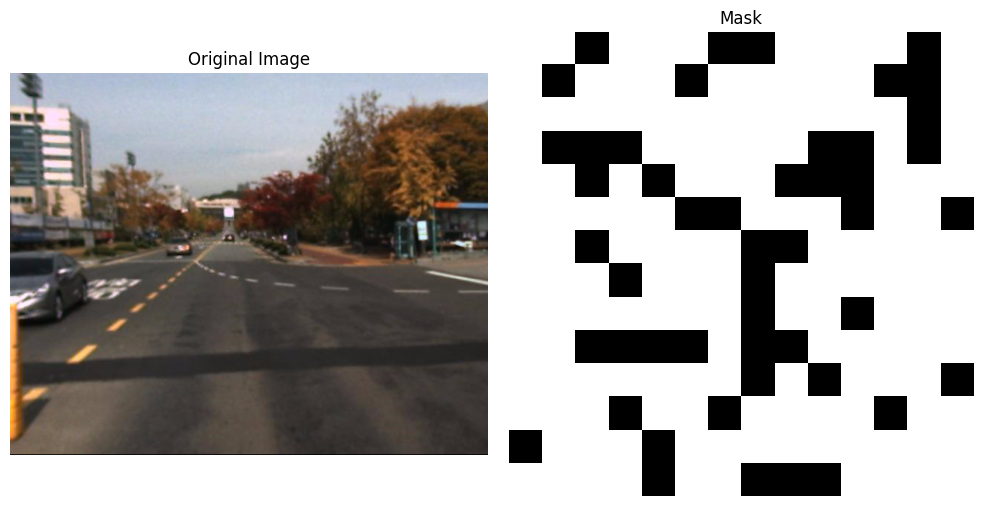

Mask Ratio: 75.00%
Number of masked patches: 147.0
Total number of patches: 196


In [3]:
import torch
from transformers import ViTMAEForPreTraining, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
model_path = "/home/hice1/swise30/training_results_thermal_gen/trained_model"
model = ViTMAEForPreTraining.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")

# Prepare a sample image
image_path = "/home/hice1/swise30/dataset/test/kaist_test_visible/set06_V000_I00019_visible.png"  # Replace with an actual image path
image = Image.open(image_path).convert("RGB")

# Process the image and run it through the model
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Get the mask and reshape it
mask = outputs.mask.squeeze().cpu().numpy()
mask_reshaped = mask.reshape(14, 14)  # Assuming 14x14 patches for a 224x224 image

# Visualize the mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_reshaped, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print mask statistics
mask_ratio = mask.sum() / mask.size
print(f"Mask Ratio: {mask_ratio:.2%}")
print(f"Number of masked patches: {mask.sum()}")
print(f"Total number of patches: {mask.size}")